In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, utils
from skimage import io
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time

In [2]:
plt.ion()

In [3]:
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/FDR/groundtruth/'
allFiles = glob.glob(datadir + "*.xml")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    parsedXML = ET.parse( file_ )
    a=file_.split('/')
    a=a[len(a)-1]
    a=a.split('.xml')
    data = {}
    for k,el in enumerate(parsedXML.iterfind('./*')):
        data[k]=[a[0]+"_"+list(el.items()[0])[1]]
        for i in el.iterfind('*'):
            data[k].append(int(list(i.items()[0])[1]))
            eye=[]
            for j in i.iterfind('*'):
                if (list(j.items()[0])[1]!=np.nan and list(j.items()[1])[1]!=np.nan):
                    eye.append([int(list(j.items()[0])[1]),int(list(j.items()[1])[1])])
            data[k].append(eye)
    
    df = pd.DataFrame.from_dict(data, orient='index', columns = ['img_number', 'ID', 'eye'])
    list_.append(df)
frame = pd.concat(list_,sort=False)
frame=frame.reset_index(drop=True)
frame=frame.drop([38074,38405],axis=0)
frame=frame.reset_index(drop=True)

In [4]:
#a=np.where(frame['ID'].isnull(),0,1)
#frame['human']=a
#frame=frame[frame['human']==1]
frame=frame.drop(['eye'],axis=1)
frame['ID']=frame['ID'].fillna(0)

#frame=frame.reset_index(drop=True)
frame.count()

img_number    176914
ID            176914
dtype: int64

In [5]:
frame['ID']=frame['ID'].astype(int)
frame.head()

,img_number,ID
0,P2E_S1_C3.1_00000300,0
1,P2E_S1_C3.1_00000301,0
2,P2E_S1_C3.1_00000302,0
3,P2E_S1_C3.1_00000303,0
4,P2E_S1_C3.1_00000304,0


In [6]:
def show_landmarks(image):
    """Show image with landmarks"""
    
    plt.imshow(image)
    plt.pause(0.001)

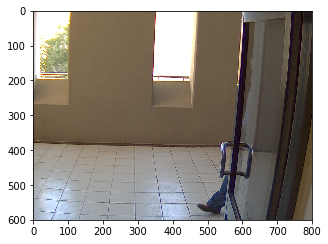

In [7]:
plt.figure(figsize=(5,4))
k=200
show_landmarks(io.imread(os.path.join('images','{}.jpg'.format(frame.loc[k]['img_number']))))

In [8]:
def gaussian(ins, is_training, mean, stddev):
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
        return ins + noise
    return ins

In [9]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, noise, flip,transform=None):
        self.df=dataframe
        self.img_dir=img_dir
        self.transform=transform
        self.noise=noise
        self.flip=flip
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image=io.imread(os.path.join(self.img_dir,'{}.jpg'.format(frame.loc[idx]['img_number'])))
        emp=self.df.loc[idx]['ID']
        sample={'image':image,'emp':emp }
        if self.transform:
            sample['image']=self.transform(sample['image'])
            sample['emp']=np.array(sample['emp'])
            if(self.flip==1):
                sample['image']=transforms.functional.hflip(sample['image'])
            sample['image']=transforms.functional.to_tensor(sample['image'])
            if (self.noise==1):
                sample['image']=gaussian(sample['image'],1,0,0.08)
            sample['emp']=torch.tensor(sample['emp'])
        return sample

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
transformed_dataset = FaceDataset(frame,img_dir='images/',noise=0,flip=0,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))
transformed_dataset2 = FaceDataset(frame,img_dir='images/',noise=1,flip=0,transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((180,240))]))

In [12]:
for i in range(1555,1559):
    sample=transformed_dataset2[i]
    print (i,sample['image'].size(),sample['emp'])

1555 torch.Size([3, 180, 240]) tensor(26)
1556 torch.Size([3, 180, 240]) tensor(26)
1557 torch.Size([3, 180, 240]) tensor(26)
1558 torch.Size([3, 180, 240]) tensor(26)


In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.pause(0.001)

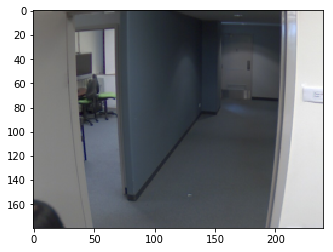

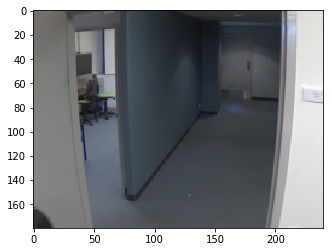

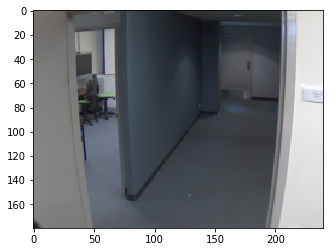

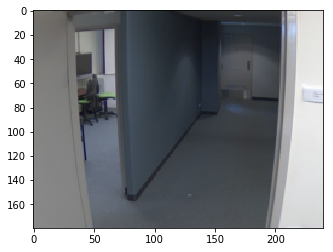

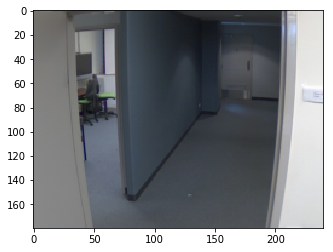

In [17]:
for i in range(3981,3986):
    sample=transformed_dataset[i]
    imshow(sample['image'])
    plt.show()

In [18]:
random.seed(0)

In [19]:
num_train=len(transformed_dataset)
indices=list(range(num_train))
split=40000
test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))
test_data = Subset(transformed_dataset,test_idx)
split=15000
validation_idx = np.random.choice(train_idx, size=split, replace=False)
train_idx = list(set(train_idx) - set(validation_idx))
train_data = Subset(transformed_dataset,train_idx)
validation_data = Subset(transformed_dataset,validation_idx)


In [20]:
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=100)
validation_loader = torch.utils.data.DataLoader(validation_data,shuffle=True,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True,batch_size=1)

In [21]:
frame['ID'].unique()

array([ 0, 14, 28, 13,  5, 30, 29,  1,  9, 24, 25, 23, 20, 10, 19,  6, 18,
       26, 27, 17, 11,  7, 16, 12,  4,  3, 15, 21, 22,  2])

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1a=nn.Conv2d(3,32,1)
        self.pool1a=nn.MaxPool2d(2,2)
        self.pool2a=nn.MaxPool2d(3,3)
        self.conv2a=nn.Conv2d(32,64,1)
        self.conv3a=nn.Conv2d(64,32,1)
        self.conv4a=nn.Conv2d(32,16,1)
        self.l1a=nn.Linear(15*20*16,200)
        self.l2a=nn.Linear(200,31)
        
        self.conv1b=nn.Conv2d(3,32,5)
        self.pool1b=nn.MaxPool2d(2,2)
        self.conv2b=nn.Conv2d(32,64,5)
        self.pool2b=nn.MaxPool2d(3,3)
        self.conv3b=nn.Conv2d(64,32,5)
        self.pool3b=nn.MaxPool2d(2,2)
        self.conv4b=nn.Conv2d(32,16,5)
        self.l1b=nn.Linear(8*13*16,200)
        self.l2b=nn.Linear(200,31)
        
        self.ReLU=nn.ReLU()
        
    def forward(self,x):
        out=self.conv1a(x)
        out=self.pool1a(out)
        out=self.ReLU(out)
        out=self.conv2a(out)
        out=self.pool2a(out)
        out=self.ReLU(out)
        out=self.conv3a(out)
        out=self.pool1a(out)
        out=self.ReLU(out)
        out=self.conv4a(out)
        out=self.ReLU(out)
        out=out.view(-1,15*20*16)
        out=self.l1a(out)
        out=self.ReLU(out)
        out=self.l2a(out)
        
        out1=self.conv1b(x)
        out1=self.pool1b(out1)
        out1=self.ReLU(out1)
        out1=self.conv2b(out1)
        out1=self.pool2b(out1)
        out1=self.ReLU(out1)
        out1=self.conv3b(out1)
        out1=self.pool3b(out1)
        out1=self.ReLU(out1)
        out1=self.conv4b(out1)
        out1=self.ReLU(out1)
        out1=out1.view(-1,8*13*16)
        out1=self.l1b(out1)
        out1=self.ReLU(out1)
        out1=self.l2b(out1)
        
        y=(out+out1)/2
        
        return y

In [23]:
model = Model()

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model=model.to(device)

cuda:0


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [26]:
checkpoint = torch.load('BB_temp.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
rl = checkpoint['loss']
acc_cv=checkpoint['validation_accuracy']

model.eval()

Model(
  (conv1a): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool1a): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2a): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3a): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4a): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (l1a): Linear(in_features=4800, out_features=200, bias=True)
  (l2a): Linear(in_features=200, out_features=31, bias=True)
  (conv1b): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1b): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2b): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2b): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3b): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool3b): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [24]:
num_epochs=1
#epochs=0
len(train_loader), epochs

(1220, 3)

Epoch: [1/1], Step: [1/10], Loss: 0.152, Average training time per batch: 1.827 seconds
Epoch: [1/1], Step: [2/10], Loss: 0.171, Average training time per batch: 1.784 seconds
Epoch: [1/1], Step: [3/10], Loss: 0.16, Average training time per batch: 1.753 seconds
Epoch: [1/1], Step: [4/10], Loss: 0.161, Average training time per batch: 1.736 seconds
Epoch: [1/1], Step: [5/10], Loss: 0.161, Average training time per batch: 1.697 seconds
Accuracy on the validation dataset: 92.633%, Time for validation: 268.332 seconds
Epoch: [1/1], Step: [6/10], Loss: 0.169, Average training time per batch: 1.748 seconds
Epoch: [1/1], Step: [7/10], Loss: 0.162, Average training time per batch: 1.802 seconds
Epoch: [1/1], Step: [8/10], Loss: 0.164, Average training time per batch: 1.81 seconds
Epoch: [1/1], Step: [9/10], Loss: 0.174, Average training time per batch: 1.762 seconds
Epoch: [1/1], Step: [10/10], Loss: 0.175, Average training time per batch: 1.767 seconds
Accuracy on the validation dataset: 92.

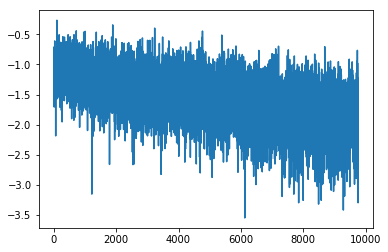

In [34]:
#acc_cv=[]
#rl=[]
for epoch in range(epochs,epochs+num_epochs):
    runningloss=0
    since = time.time()
    for i,(sample) in enumerate(train_loader):
        
        images = sample['image']
        images=images.to(device)
        labels=sample['emp']
        labels=labels.to(device)
    
        optimizer.zero_grad()
        output=model(images)
    
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        rl.append(loss.item())
        
        
        if (i+1) % 122 == 0:  
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}, Average training time per batch: {} seconds'.format(epoch+1-epochs, num_epochs, int((i+1)/122),10 , round(runningloss/122,3), round((time.time()-since)/122,3)))
            runningloss=0
            since = time.time()
        
        
            
        if (i+1)%610==0:
            correct=0
            total=0
            for j,samp in enumerate(validation_loader):
                im = Variable(samp['image'])
                im=im.to(device)
                ot = model(im)
    
                _, predicted = torch.max(ot, 1)
                total += samp['emp'].size(0)
                correct += (predicted== samp['emp'].to(device)).sum().item()
            
            acc_cv.append(correct/total)
            print ('Accuracy on the validation dataset: {}%, Time for validation: {} seconds'.format(round(acc_cv[len(acc_cv)-1]*100,3), round(time.time()-since,3)))
            since=time.time()
                   
            
                
    print ('Accuracy on the validation dataset: {}%, --Saving the model--'.format(round(acc_cv[len(acc_cv)-1]*100,3)))
    torch.save({
            'epoch': int(len(acc_cv)/2),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': rl,
            'validation_accuracy':acc_cv,
            },'BB_temp_2.pth')


plt.plot(range(len(rl)),np.log(rl))

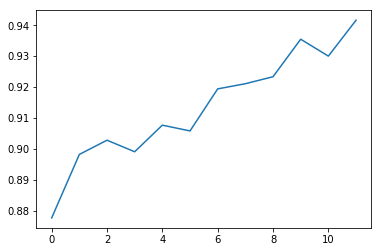

In [31]:
plt.plot(range(len(acc_cv)),(acc_cv))

In [32]:
torch.save({
            'epoch': int(len(acc_cv)/2),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': rl,
            'validation_accuracy':acc_cv,
            },'BB_temp.pth')

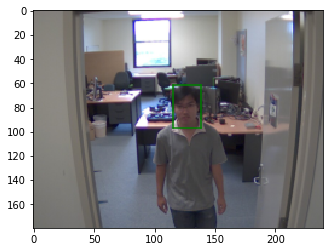

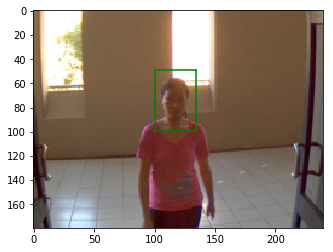

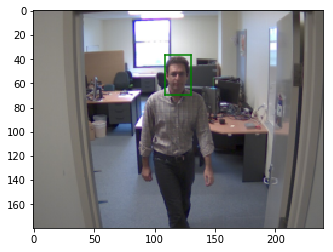

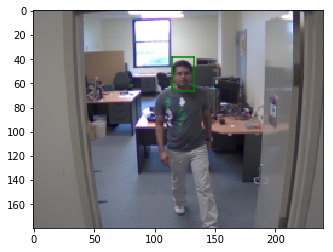

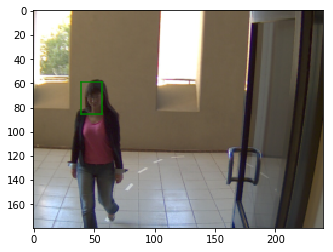

In [42]:
for j,samp in enumerate(validation_loader):
    im = Variable(samp['image'])
    lb=samp['eye']
    im=im.to(device)
    ot = model(im)
    imshow(im.cpu()[0],ot.cpu()[0].detach().numpy())
    #imshow(im.cpu()[0],lb.cpu()[0].detach().numpy())
    if(j>=4):
        break
#plt.show()


In [27]:
correct=0
total=0
tp=0
fp=0
fn=0
tn=0
for j,samp in enumerate(test_loader):
    im = Variable(samp['image'])
    im=im.to(device)
    ot = model(im)
    
    _, predicted = torch.max(ot, 1)
    total += samp['emp'].size(0)
    correct += (predicted== samp['emp'].to(device)).sum().item()
    samplab=samp['emp'].to(device)
    
    tp=tp+len([i for i in range(len(predicted)) if samplab[i]==1 and predicted[i]==1])
    tn=tn+len([i for i in range(len(predicted)) if samplab[i]==0 and predicted[i]==0])
    fp=fp+len([i for i in range(len(predicted)) if samplab[i]==0 and predicted[i]==1])
    fn=fn+len([i for i in range(len(predicted)) if samplab[i]==1 and predicted[i]==0])
    
    
print ('Accuracy on test data:{}'.format(correct/total))
print('Precision of the network: %f %%' % (tp/(tp+fp)))
print('Recall/Sensitivity/TPR of the network: %f %%' % (tp/(tp+fn)))
print('TNR/Specifity/Selectivity of the network: %f %%' % (tn/(tn+fp)))

Accuracy on test data:0.947325
Precision of the network: 0.971014 %
Recall/Sensitivity/TPR of the network: 0.962298 %
TNR/Specifity/Selectivity of the network: 0.999307 %
